<a href="https://colab.research.google.com/github/srikarraju/eGrocery_Demand_Prediction/blob/main/NAC_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
class Gridworld:
  def __init__(self,grid_dim=4):
    self.grid_dim = grid_dim
    self.number_states = self.grid_dim*self.grid_dim - 1
    self.curr_state = 0

  def reset(self):
    self.curr_state = 0
    return self.curr_state

  def step(self,state,action):
    curr_state = (int(state/self.grid_dim),state%self.grid_dim)
    if action == 0:#Left
      if curr_state[1]-1<0:
        return state,-1,0
      else:
        next_state = (curr_state[0],curr_state[1]-1)
        if next_state[0]==self.grid_dim-1 and next_state[1]==self.grid_dim-1:
          return next_state[0]*self.grid_dim + next_state[1],0,1
        else:
          return next_state[0]*self.grid_dim + next_state[1],-1,0
    elif action ==1:#Right
      if curr_state[1]+1>=self.grid_dim:
        return state,-1,0
      else:
        next_state = (curr_state[0],curr_state[1]+1)
        if next_state[0]==self.grid_dim-1 and next_state[1]==self.grid_dim-1:
          return next_state[0]*self.grid_dim + next_state[1],0,1
        else:
          return next_state[0]*self.grid_dim + next_state[1],-1,0
    elif action ==2:#Up
      if curr_state[0]-1<0:
        return state,-1,0
      else:
        next_state = (curr_state[0]-1,curr_state[1])
        if next_state[0]==self.grid_dim-1 and next_state[1]==self.grid_dim-1:
          return next_state[0]*self.grid_dim + next_state[1],0,1
        else:
          return next_state[0]*self.grid_dim + next_state[1],-1,0
    elif action ==3:#Down
      if curr_state[0]+1>=self.grid_dim:
        return state,-1,0
      else:
        next_state = (curr_state[0]+1,curr_state[1])
        if next_state[0]==self.grid_dim-1 and next_state[1]==self.grid_dim-1:
          return next_state[0]*self.grid_dim + next_state[1],0,1
        else:
          return next_state[0]*self.grid_dim + next_state[1],-1,0
    else:
      print("Invalid Action")
      return None,0,1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
from collections import deque
import numpy as np

In [ ]:
def generate_state_features(grid_dim):
  state_features = []
  for row in range(grid_dim):
    for col in range(grid_dim):
      state_features.append([row,col])
  state_features = np.asarray(state_features)
  return state_features

In [ ]:
def generate_state_action_features(state_vec, d,num_actions):
  state_action_features = np.zeros(shape=(num_actions,d+num_actions))
  for i in range(num_actions):
    for j in range(d):
      state_action_features[i][j] = state_vec[j]
  state_action_features[0][d] = 1
  state_action_features[1][d+1] =  1
  state_action_features[2][d+2] =  1
  state_action_features[3][d+3] =  1
  return state_action_features

In [ ]:
class policy_net(nn.Module):
  def __init__(self,state_dim,hidden_dim,action_dim):
    super(policy_net,self).__init__()
    self.h = nn.Linear(state_dim,hidden_dim)
    self.out = nn.Linear(hidden_dim,action_dim)

  def forward(self,x):
    x = F.relu(self.h(x))
    x = F.softmax(self.out(x),dim=1)
    return x

In [ ]:
class value_net(nn.Module):
  def __init__(self,state_dim,hidden_dim):
    super(value_net,self).__init__()
    self.h = nn.Linear(state_dim,hidden_dim)
    self.out = nn.Linear(hidden_dim,1)

  def forward(self,x):
    x = self.h(x)
    x = nn.ReLU()(x)
    x = self.out(x)
    return x

In [ ]:
grid_dim = 4
num_actions = 4
d = 2

env = Gridworld(grid_dim)
policy = policy_net(d,8,num_actions)
value_fn = value_net(d,8)

optimizer1 = torch.optim.SGD(policy.parameters(),lr=1)
optimizer2 = torch.optim.SGD(value_fn.parameters(),lr=1)

returns = deque(maxlen=100)

In [ ]:
# ALGORITHM 1
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 100000
t = 0
n_episode = 0
actions_list = []
avg_reward = 0

state_features = generate_state_features(grid_dim)
while n_episode <=2000:
  rewards,states,actions = [],[],[]
  state = 0
  # state = env.reset()
  t = 0
  episode_len = 0
  while episode_len<=100:
    episode_len += 1
    probs = policy(torch.tensor(state_features[state]).unsqueeze(0).float())
    #probs = policy(torch.tensor(state).unsqueeze(0).float())
    probs = probs.squeeze(0)
    sampler = Categorical(probs)
    action = sampler.sample()

    new_state, reward, done = env.step(state,action.item())
    #new_state, reward, done,info = env.step(action.item())

    value_curr = value_fn(torch.tensor(state_features[state]).unsqueeze(0).float())
    value_next = value_fn(torch.tensor(state_features[new_state]).unsqueeze(0).float())

    #value_curr = value_fn(torch.tensor(state).unsqueeze(0).float())
    #value_next = value_fn(torch.tensor(new_state).unsqueeze(0).float())

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)* avg_reward + gamma * alpha* reward
    td_error = reward + value_next - value_curr - avg_reward
    td_error = td_error.detach()
    td_error = td_error.item()

    value_net_loss = -alpha*td_error*value_curr
    optimizer2.zero_grad()
    value_net_loss.backward()
    optimizer2.step()

    policy_net_loss = -beta*td_error*probs[action]
    optimizer1.zero_grad()
    policy_net_loss.backward()
    optimizer1.step()

    states.append(state)
    actions.append(action)
    rewards.append(reward)
    actions_list.append(action)

    state = new_state
    if done == 1:
      break

  returns.append(np.sum(rewards))
  if n_episode%100==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
    #state = 0
    #state_value = value_fn(torch.tensor(state_features[state]).unsqueeze(0).float())
    #print(state_value)
  n_episode += 1

In [ ]:
grid_dim = 4
num_actions = 4
d = 2
env = Gridworld(grid_dim)

value_fn = value_net(d,8)
optimizer2 = torch.optim.SGD(value_fn.parameters(),lr=1)

returns = deque(maxlen=50)
weights_p = np.zeros(6,dtype=float)

rewards2 = []

print(weights_p)

[0. 0. 0. 0. 0. 0.]


In [ ]:
#ALGORITHM 2
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 1000
t = 0
n_episode = 0
avg_reward = 0

fischer_inv = 1.5*np.eye(6)
state_features = generate_state_features(grid_dim)

while n_episode <=2000:
  rewards,states,actions = [],[],[]
  state = 0
  episode_len = 0

  while episode_len<100:
    episode_len += 1
    t += 1

    state_action_features = generate_state_action_features(state_features[state],d,num_actions)
    probs = np.dot(state_action_features,weights_p)
    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()

    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward, done = env.step(state,action)

    value_curr = value_fn(torch.tensor(state_features[state]).unsqueeze(0).float())
    value_next = value_fn(torch.tensor(state_features[new_state]).unsqueeze(0).float())

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward
    td_error = reward + value_next - value_curr - avg_reward
    td_error = td_error.detach()
    td_error = td_error.item()

    value_net_loss = -alpha* td_error*value_curr
    optimizer2.zero_grad()
    value_net_loss.backward()
    optimizer2.step()

    grad_prob = probs[action]*(1-probs[action])*state_action_features[action]

    Gt_psi_dot = np.dot(fischer_inv, grad_prob)
    fischer_inv -= (0.00001*alpha * np.outer(Gt_psi_dot,Gt_psi_dot) ) / (1 - 0.0001*alpha + 0.00001*alpha * np.dot(Gt_psi_dot,grad_prob))
    fischer_inv /= (1 - 0.00001*alpha)

    weights_p += 0.05*beta * td_error * np.dot(fischer_inv,grad_prob)

    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = new_state
    if done==1:
      break

  returns.append(np.sum(rewards))
  if n_episode%50==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  rewards2.append(np.mean(returns))
  n_episode += 1

Episode:      0	Avg. Return: -14.00
Episode:     50	Avg. Return: -51.60
Episode:    100	Avg. Return: -38.02
Episode:    150	Avg. Return: -37.08
Episode:    200	Avg. Return: -41.34
Episode:    250	Avg. Return: -46.66
Episode:    300	Avg. Return: -40.06
Episode:    350	Avg. Return: -42.56
Episode:    400	Avg. Return: -40.18
Episode:    450	Avg. Return: -38.88
Episode:    500	Avg. Return: -34.46
Episode:    550	Avg. Return: -45.34
Episode:    600	Avg. Return: -38.76
Episode:    650	Avg. Return: -35.48
Episode:    700	Avg. Return: -38.92
Episode:    750	Avg. Return: -42.08
Episode:    800	Avg. Return: -40.04
Episode:    850	Avg. Return: -39.24
Episode:    900	Avg. Return: -34.92
Episode:    950	Avg. Return: -31.54
Episode:   1000	Avg. Return: -35.92
Episode:   1050	Avg. Return: -32.52
Episode:   1100	Avg. Return: -27.60
Episode:   1150	Avg. Return: -37.62
Episode:   1200	Avg. Return: -40.16
Episode:   1250	Avg. Return: -35.32
Episode:   1300	Avg. Return: -37.32
Episode:   1350	Avg. Return:

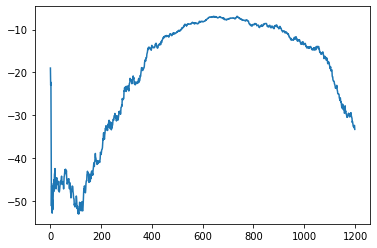

In [ ]:
import matplotlib.pyplot as plt
plt.plot(rewards2[:1200])
plt.show()

In [ ]:
grid_dim = 4
num_actions = 4
d = 2
env = Gridworld(grid_dim)

value_fn = value_net(d,8)
optimizer2 = torch.optim.SGD(value_fn.parameters(),lr=1)

returns = deque(maxlen=50)
weights_p = np.zeros(6,dtype=float)
weights_w = np.zeros(6,dtype=float)
rewards_4 = []
print(weights_p)
print(weights_w)

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


In [ ]:
# ALGORITHM 4
alpha_0, beta_0, gamma, epsilon = 0.1, 0.01, 0.95, 0.1
alpha_c, beta_c = 1000, 1000
t = 0
n_episode = 0
avg_reward = 0

fischer_inv = 2.5*np.eye(6)
state_features = generate_state_features(grid_dim)

while n_episode <=10000:
  rewards,states,actions = [],[],[]
  state = 0
  episode_len = 0

  while episode_len<100:
    episode_len += 1
    t += 1

    state_action_features = generate_state_action_features(state_features[state],d,num_actions)
    probs = np.dot(state_action_features,weights_p)
    probs -= probs.max()
    probs = np.exp(np.clip(probs/epsilon, -500, 500))
    probs /= probs.sum()

    probs2 = probs.cumsum()
    action = np.where(probs2 >= np.random.random())[0][0]

    new_state, reward, done = env.step(state,action)

    value_curr = value_fn(torch.tensor(state_features[state]).unsqueeze(0).float())
    value_next = value_fn(torch.tensor(state_features[new_state]).unsqueeze(0).float())

    beta = (beta_0 * beta_c) / (beta_c + t)
    alpha = (alpha_0 * alpha_c) / (alpha_c + t**(2/3))

    avg_reward = (1 - alpha*gamma)*avg_reward + alpha*gamma * reward
    td_error = reward + value_next - value_curr -avg_reward
    td_error = td_error.detach()
    td_error = td_error.item()

    value_net_loss = -0.1*alpha* td_error*value_curr
    optimizer2.zero_grad()
    value_net_loss.backward()
    optimizer2.step()

    grad_prob = probs[action]*(1-probs[action])*state_action_features[action]

    Gt_psi_dot = np.dot(fischer_inv, grad_prob)
    fischer_inv -= (0.00001*alpha * np.outer(Gt_psi_dot,Gt_psi_dot) ) / (1 - 0.00001*alpha + 0.00001*alpha * np.dot(Gt_psi_dot,grad_prob))
    fischer_inv /= (1 - 0.00001*alpha)
    weights_w = (1- alpha) *weights_w + alpha* td_error * np.dot(fischer_inv,grad_prob)

    weights_p += beta * weights_w

    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = new_state
    if done==1:
      break

  returns.append(np.sum(rewards))
  if n_episode%50==0:
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
  rewards_4.append(np.mean(returns))
  n_episode += 1

Episode:      0	Avg. Return: -22.00
Episode:     50	Avg. Return: -24.32
Episode:    100	Avg. Return: -15.58
Episode:    150	Avg. Return: -11.10
Episode:    200	Avg. Return: -12.72
Episode:    250	Avg. Return: -12.38
Episode:    300	Avg. Return:  -9.20
Episode:    350	Avg. Return:  -9.42
Episode:    400	Avg. Return: -10.66
Episode:    450	Avg. Return: -14.20
Episode:    500	Avg. Return: -10.76
Episode:    550	Avg. Return:  -9.06
Episode:    600	Avg. Return:  -7.42
Episode:    650	Avg. Return:  -7.24
Episode:    700	Avg. Return:  -7.88
Episode:    750	Avg. Return:  -7.14
Episode:    800	Avg. Return:  -8.24
Episode:    850	Avg. Return:  -6.60
Episode:    900	Avg. Return:  -7.44
Episode:    950	Avg. Return:  -7.66
Episode:   1000	Avg. Return:  -7.30
Episode:   1050	Avg. Return:  -7.04
Episode:   1100	Avg. Return:  -7.26
Episode:   1150	Avg. Return:  -7.40
Episode:   1200	Avg. Return:  -7.02
Episode:   1250	Avg. Return:  -7.66
Episode:   1300	Avg. Return:  -7.48
Episode:   1350	Avg. Return:

-6.04


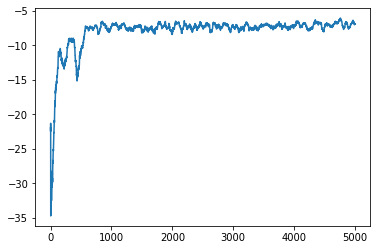

In [ ]:
import matplotlib.pyplot as plt
print(max(rewards_4))
plt.plot(rewards_4[0:5000])
plt.show()

In [ ]:
print(states)
print(actions)
print(probs)

[0, 1, 2, 6, 10, 14, 14, 14, 14]
[1, 1, 3, 3, 3, 3, 3, 3, 1]
[8.60676205e-18 3.06418724e-01 8.61047689e-18 6.93581276e-01]


In [ ]:
print(t)

50188


In [ ]:
for i in range(16):
  print(value_fn(torch.tensor(state_features[i]).unsqueeze(0).float()))

tensor([[1501.4282]], grad_fn=<AddmmBackward>)
tensor([[2413.3667]], grad_fn=<AddmmBackward>)
tensor([[3325.3052]], grad_fn=<AddmmBackward>)
tensor([[4237.2432]], grad_fn=<AddmmBackward>)
tensor([[2459.1509]], grad_fn=<AddmmBackward>)
tensor([[3371.0891]], grad_fn=<AddmmBackward>)
tensor([[4283.0269]], grad_fn=<AddmmBackward>)
tensor([[5194.9663]], grad_fn=<AddmmBackward>)
tensor([[3416.8733]], grad_fn=<AddmmBackward>)
tensor([[4328.8110]], grad_fn=<AddmmBackward>)
tensor([[5240.7500]], grad_fn=<AddmmBackward>)
tensor([[6152.6890]], grad_fn=<AddmmBackward>)
tensor([[4374.5952]], grad_fn=<AddmmBackward>)
tensor([[5286.5342]], grad_fn=<AddmmBackward>)
tensor([[6198.4722]], grad_fn=<AddmmBackward>)
tensor([[7110.4106]], grad_fn=<AddmmBackward>)


In [ ]:
for p in value_fn.parameters():
  print(p)

Parameter containing:
tensor([[-0.5016,  0.2848],
        [ 0.1561,  0.2170],
        [-0.6995, -0.4611],
        [-0.6962,  0.6301],
        [-0.2343,  0.0749],
        [ 0.6443,  0.4449],
        [ 0.4607,  0.1512],
        [-0.5915,  0.5608]], requires_grad=True)
Parameter containing:
tensor([-0.0181, -0.5126,  0.1011, -0.0010, -0.5065,  0.5647, -0.2680, -0.3557],
       requires_grad=True)
Parameter containing:
tensor([[-0.1036,  0.2231,  0.2198,  0.1271, -0.2496, -0.0685, -0.2228, -0.0800]],
       requires_grad=True)
Parameter containing:
tensor([-0.0080], requires_grad=True)
